# Autoencoders and prediction of extremely infrequent classes

Here we will train a binary classification model using Autoencoders. The objective is to train a model capable of classifying an event that occurs very few times, and for which we have hardly any data. This code is based on the https://github.com/cran2367/ github.

We will use the same data set as Creditcard

**What is an extremely rare event?**
In a rare event problem, we have an unbalanced data set. That is, we have fewer positively labeled samples than negatively labeled samples. In a typical rare event problem, positively labeled data is about 5-10% of the total. In an extremely rare event problem, we have **less than 1% positively labeled data**. For example, in the data set used here it is about 0.6%.
These extreme rare event problems are quite common in the real world, e.g. machine breakdowns, bank frauds, etc.

Classifying these rare events is quite difficult. The small amount of positively labeled samples prohibits the application of Deep Learning . No matter how big the data is, the use of Deep Learning is limited by the number of positively labeled samples.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
"""from tensorflow import set_random_seed
set_random_seed(2)"""

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("data/creditcard.csv.zip", compression='zip')
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [4]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In the automatic encoder, we will encode only the negatively labeled data. That is, we will take the part of data for which y = 0 and build an automatic encoder. For that, we will divide the data sets as follows.

In [5]:
df_train_0 = df_train.loc[df['Class'] == 0]
df_train_1 = df_train.loc[df['Class'] == 1]
df_train_0_x = df_train_0.drop(['Class'], axis=1)
df_train_1_x = df_train_1.drop(['Class'], axis=1)

df_valid_0 = df_valid.loc[df['Class'] == 0]
df_valid_1 = df_valid.loc[df['Class'] == 1]
df_valid_0_x = df_valid_0.drop(['Class'], axis=1)
df_valid_1_x = df_valid_1.drop(['Class'], axis=1)

df_test_0 = df_test.loc[df['Class'] == 0]
df_test_1 = df_test.loc[df['Class'] == 1]
df_test_0_x = df_test_0.drop(['Class'], axis=1)
df_test_1_x = df_test_1.drop(['Class'], axis=1)

### Standardize the data
In general, it is best to use standardized data (transformed to Gaussian, mean 0 and sd 1) for automatic encoders.

In [7]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['Class'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['Class'], axis = 1))

First we will initialize the Autoencoder architecture. We are building a simple Autoencoder. More complex architectures and other configurations should be explored.

In [8]:
nb_epoch = 100
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)

decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 32)                992       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 30)                990       
                                                  

2022-07-24 18:53:17.091575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 18:53:17.092120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/100


2022-07-24 18:53:33.141239: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 18:53:33.562449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1422/1422 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.3597

2022-07-24 18:53:43.682985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1422/1422 [==============================] - 12s 8ms/step - loss: 0.5322 - accuracy: 0.3597 - val_loss: 0.3238 - val_accuracy: 0.5007
Epoch 2/100
1422/1422 [==============================] - 12s 8ms/step - loss: 0.2612 - accuracy: 0.5508 - val_loss: 0.2111 - val_accuracy: 0.5885
Epoch 3/100
1422/1422 [==============================] - 10s 7ms/step - loss: 0.1978 - accuracy: 0.6077 - val_loss: 0.1766 - val_accuracy: 0.6299
Epoch 4/100
1422/1422 [==============================] - 12s 8ms/step - loss: 0.1728 - accuracy: 0.6346 - val_loss: 0.1591 - val_accuracy: 0.6490
Epoch 5/100
1422/1422 [==============================] - 11s 8ms/step - loss: 0.1586 - accuracy: 0.6582 - val_loss: 0.1483 - val_accuracy: 0.6698
Epoch 6/100
1422/1422 [==============================] - 11s 7ms/step - loss: 0.1476 - accuracy: 0.6818 - val_loss: 0.1522 - val_accuracy: 0.6777
Epoch 7/100
1422/1422 [==============================] - 13s 9ms/step - loss: 0.1385 - accuracy: 0.7038 - val_loss: 0.1274 - val_accurac

In [10]:
autoencoder = load_model('autoencoder_classifier.h5')

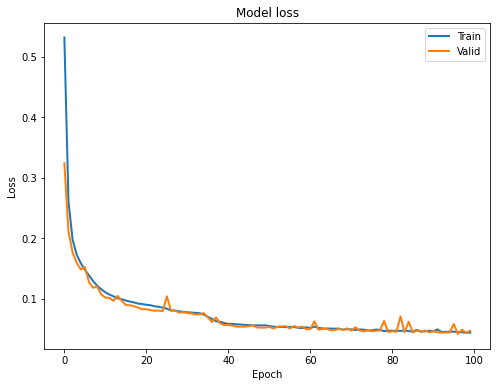

In [11]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Classification

Next, we show how we can use an Autoencoder reconstruction error for rare event classification.
As mentioned above, if the reconstruction error is high, we will classify it as a fraudulent operation. We will need to determine the threshold for this.
We will use the validation set to identify the threshold. We should not estimate the classification threshold from the test data. It will result in an **overfit**.

In [12]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['Class']})

   2/1425 [..............................] - ETA: 1:31 

2022-07-24 19:19:41.876874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1425/1425 [==============================] - 4s 2ms/step


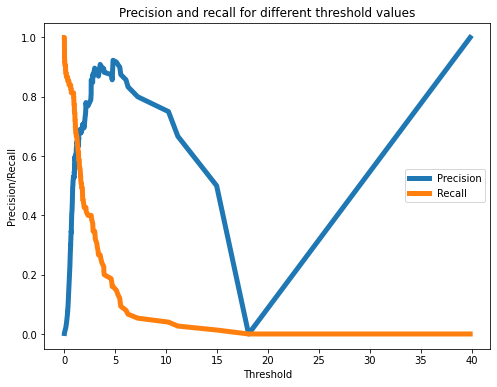

In [13]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

A threshold of 4 should provide a reasonable trade-off between accuracy and recovery.

In [14]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['Class']})
error_df_test = error_df_test.reset_index()

1781/1781 [==============================] - 3s 2ms/step


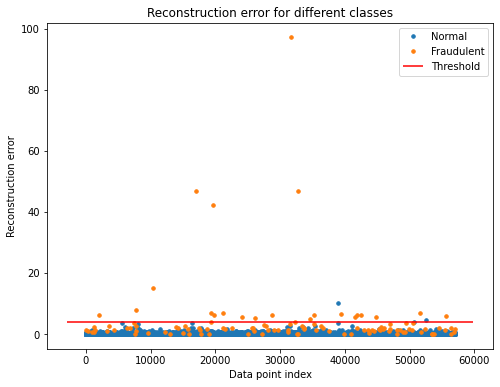

In [15]:
threshold_fixed = 4
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraudulent" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Using threshold = 4 for classification. The orange and blue dots above the threshold line represent true positive and false positive, respectively.

In [16]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [17]:
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})

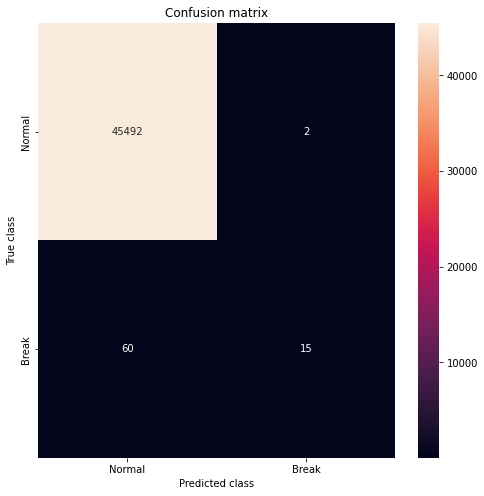

In [18]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

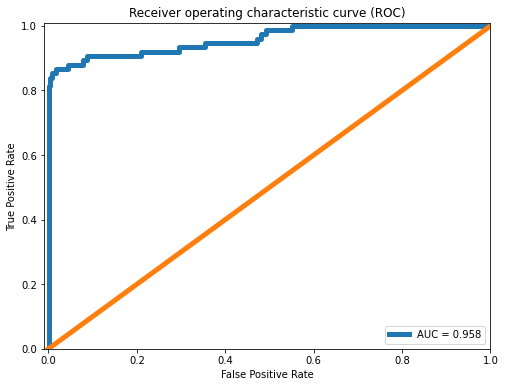

In [19]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()